This file iterates through UMich's XML files that contain the raw transcription for EEBO to identify italicized markups. Especially look for the parseXMLFolder Python class object. It contains most of the functions.

Author: Jerry Zou

In [18]:
# from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import os, random, json
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

In [ ]:
# INFORMATIONAL DATA WRANGLING CODE. CUSTOMIZE OUTPUT TO FIT THE GOAL OF EACH USAGE
# These two functions grab the file names of all XML files in both Phases One and Two. This code cell is more for informational purposes, such as checking the number of files in each directory, etc.
folderPathEEBOOne = "/Volumes/JZ/EEBOData+2024/eebo_phase1/P4_XML_TCP"
folderPathEEBOTwo = "/Volumes/JZ/EEBOData+2024/eebo_phase2/P4_XML_TCP_Ph2"
fileNameListEEBOOne = []
fileNameListEEBOTwo = []
def findAllFileNamesEEBOOne(folderPathname):
    for root, subFolderList, files in os.walk(folderPathname):
        for fileName in files:
            if fileName.endswith(".xml"):
                fullFilePathName = os.path.join(root, fileName)
                fileNameListEEBOOne.append(os.path.basename(fullFilePathName)[:-4])
def findAllFileNamesEEBOTwo(folderPathname):
    for root, subFolderList, files in os.walk(folderPathname):
        for fileName in files:
            if fileName.endswith(".xml"):
                fullFilePathName = os.path.join(root, fileName)
                fileNameListEEBOTwo.append(os.path.basename(fullFilePathName)[:-4])

print("Traversing EEBO Phase One directory tree...")
findAllFileNamesEEBOOne(folderPathEEBOOne)
print("EEBO Phase One directory successfully traversed to store XML file paths.")
print("Traversing EEBO Phase Two directory tree...")
findAllFileNamesEEBOTwo(folderPathEEBOTwo)
print("EEBO Phase Two directory successfully traversed to store XML file paths.")

# ----- CUSTOMIZE WRANGLING USAGE CODE BELOW: -----
# print(len(fileNameListEEBOOne))
# print(len(fileNameListEEBOTwo))
# print(sort(fileNameListEEBOOne))

In [19]:
'''This code cell is designed to search folders of XML files for general parsing purposes. The result will be stored in a JSON file. If running on local machine, make sure to add an iteration code so that the data gets pushed to JSON after a set amount of iterations so that the program doesn't exceed the local machine's memory storage space.

Currently, this program processes each file according to the line number of the italicized words to determine distribution.

We need a function to determine the total line number of every file path so that when we create dispersion plots, they are proportional to each file.

For the JSON file in which the output data is stored, the format for the dictionary is:
{filename (string) : {line number (integer) : sentence content (string)}}'''

class parseXMLFolder:
    def __init__(self, jsonPathRaw, jsonPathFiltered, folderPathEEBOOne, folderPathEEBOTwo, tag):
        self.jsonPathRaw = jsonPathRaw
        self.folderPaths = [folderPathEEBOOne, folderPathEEBOTwo] #lsit of two lists of file paths
        self.tagsAsJson = tag
        self.tagAsList = []

    def turnTagsIntoList(self):
        with open(self.tagsAsJson, "r") as file:
            tagsJsonFormat = json.load(file)
        for tagSubList in tagsJsonFormat.values():
            for specificTag in tagSubList:
                self.tagAsList.append(specificTag)
        print(type(self.tagAsList))
        
    def openFiles(self, filePathsList):
        contentDictionary = {}
        for filePath in filePathsList:
            with open(filePath, "r", encoding="utf-8") as file:
                fileContent = file.read()  # Read the entire file content
            fileDictionaryKey = os.path.basename(filePath)[:-4]
            contentDictionary[fileDictionaryKey] = [{}]  # Initialize with a list containing an empty dictionary
            tree = ET.ElementTree(ET.fromstring(fileContent))
            root = tree.getroot()
            def extract_text(element):
                text = element.text or ""
                for subelement in element:
                    text += ET.tostring(subelement, encoding='unicode', method='text')
                    if subelement.tail:
                        text += subelement.tail
                return text

            # Traverse and find all specified tags
            for oneTag in self.tagAsList:
                tagDict = {}
                for tag in root.iter(oneTag):
                    tag_text = extract_text(tag)
                    tag_str = ET.tostring(tag, encoding='unicode').strip()
                    start_index = fileContent.find(tag_str)
                    if start_index == -1:
                        continue
                    lineNum = fileContent[:start_index].count('\n') + 1
                    if lineNum not in tagDict:
                        tagDict[lineNum] = []
                    tagDict[lineNum].append(tag_text)
                contentDictionary[fileDictionaryKey][0][oneTag] = tagDict
        print(contentDictionary)
        return contentDictionary

    def addBatchToJson(self, newBatch):
        try:
            with open(self.jsonPathRaw, "r", encoding="utf-8") as file:
                currentData = json.load(file)
        except (FileNotFoundError, json.JSONDecodeError):
            currentData = {}  # Added exception handling for file not found or invalid JSON
        currentData.update(newBatch)
        with open(self.jsonPathRaw, "w", encoding="utf-8") as file:
            json.dump(currentData, file, indent=4)

    def preprocessForJson(self):
        allFileNames = []
        for folder in self.folderPaths:
            for root, subFolder, files in os.walk(folder):
                for fileName in files:
                    if fileName.endswith(".xml"):
                        fullFilePathName = os.path.join(root, fileName)
                        allFileNames.append(fullFilePathName)
        batchLength = 1 # The "batchLength" variable is designed to be a safety pin. It limits how many files are being processed at once. Change this number depending on how many files the device memory allows to store. If you are using a large machine, such as Duke Cluster Computers, this number shoudn't matter as much. Just don't crash whichever device you are using.
        for fileCount in range(0, len(allFileNames), batchLength):
            batchXML = allFileNames[fileCount:fileCount + batchLength]
            newParsing = self.openFiles(batchXML)
            self.addBatchToJson(newParsing)


    # under development:
    # def filterResults(self, jsonPathRaw, jsonPathFiltered, citationIndicators):
    #     with open(jsonPathRaw, "r") as file:
    #     for indicator in citationIndicators:
    #         if 

jPathRawExtracts = "StoringItalicsAndLineNumber.json"
jpathFiltered = ""
EEBOOne = "/Users/Jerry/Desktop/A0"
EEBOTwo = "/Users/Jerry/Desktop/A01"
tagPath = "XMLCitationTags.json"

# calling Python object
parcer = parseXMLFolder(jPathRawExtracts, jpathFiltered, EEBOOne, EEBOTwo, tagPath)
parcer.turnTagsIntoList()
parcer.preprocessForJson()

<class 'list'>
{'A00011.P4': [{'HI': {38: ['AGAINST'], 40: ['SYNOD,'], 41: ['CONVENTICLE,'], 43: ['Religion', 'Christ,'], 45: ['Kingdome and Crowne.', 'Complaint', 'impieties', 'insolencies,'], 46: ['Canons', 'Constitutions,'], 47: ['Synod.', 'Arguments', 'Synod.'], 48: ['Psal. 94. 20, 21, &c.'], 51: ['Esa.'], 54: ['Ezech. 22. 24, 25, &c.'], 59: ['&c.', '&c.'], 60: ['Printed'], 73: ['Israel,'], 89: ['Lord,'], 91: ['afflictions', 'oppressions,', 'wor∣thily'], 92: ['Thou\nhast'], 93: ['tryed us,', 'melted', 'silver:'], 94: ['net:', 'affliction'], 95: ['loynes:'], 96: ['healing,'], 97: ['smitten us:', 'binding up,', 'broken'], 98: ['torne us?'], 99: ['Iudge of all the world,'], 100: ['feeling of our infirmities,'], 101: ['in all things tempted like as we are,'], 102: ['come boldly to the throne of Grace, and obtaine mercy,\nand find grace to helpe in time of need'], 105: ['Righteous Throne:'], 106: ['Throne of Iniquity frameth mischiefe as by a Law.'], 110: ['deep hypocrisie, double iniqu

In [17]:
import os
import json
from bs4 import BeautifulSoup

class parseXMLFolder:
    def __init__(self, jsonPathRaw, jsonPathFiltered, folderPathEEBOOne, folderPathEEBOTwo, tag):
        self.jsonPathRaw = jsonPathRaw
        self.folderPaths = [folderPathEEBOOne, folderPathEEBOTwo] # List of two folder paths
        self.tagsAsJson = tag
        self.tagAsList = []

    def turnTagsIntoList(self):
        with open(self.tagsAsJson, "r") as file:
            tagsJsonFormat = json.load(file)
        for tagSubList in tagsJsonFormat.values():
            for specificTag in tagSubList:
                self.tagAsList.append(specificTag)

    def openFiles(self, filePathsList):
        contentDictionary = {}
        for filePath in filePathsList:
            with open(filePath, "r", encoding="utf-8") as file:
                fileContent = file.read()
            fileDictionaryKey = os.path.basename(filePath)[:-4]
            contentDictionary[fileDictionaryKey] = {}

            soupContent = BeautifulSoup(fileContent, "xml")
            contentPointer = 0
            def get_line_number(start_index, content):
                return content[:start_index].count('\n') + 1
            for oneTag in self.tagAsList:
                taggedContent = soupContent.find_all(oneTag)
                for tag in taggedContent:
                    tag_str = str(tag)
                    start_index = fileContent.find(tag_str, contentPointer)
                    lineNum = get_line_number(start_index, fileContent)
                    if lineNum not in contentDictionary[fileDictionaryKey]:
                        contentDictionary[fileDictionaryKey][lineNum] = []
                    contentDictionary[fileDictionaryKey][lineNum].append(tag.text)
                    contentPointer = start_index + len(tag_str)  # Move the pointer forward
        return contentDictionary

    def addBatchToJson(self, newBatch):
        try:
            with open(self.jsonPathRaw, "r", encoding="utf-8") as file:
                currentData = json.load(file)
        except (FileNotFoundError, json.JSONDecodeError):
            currentData = {}  # Handle file not found or invalid JSON
        currentData.update(newBatch)
        with open(self.jsonPathRaw, "w", encoding="utf-8") as file:
            json.dump(currentData, file, indent=4)

    def preprocessForJson(self):
        allFileNames = []
        for folder in self.folderPaths:
            for root, _, files in os.walk(folder):
                for fileName in files:
                    if fileName.endswith(".xml"):
                        fullFilePathName = os.path.join(root, fileName)
                        allFileNames.append(fullFilePathName)
        batchLength = 10  # Adjust batch length as needed
        for fileCount in range(0, len(allFileNames), batchLength):
            batchXML = allFileNames[fileCount:fileCount + batchLength]
            newParsing = self.openFiles(batchXML)
            self.addBatchToJson(newParsing)

jPathRawExtracts = "StoringItalicsAndLineNumber.json"
jpathFiltered = ""
EEBOOne = "/Users/Jerry/Desktop/A0"
EEBOTwo = "/Users/Jerry/Desktop/A01"
tagPath = "XMLCitationTags.json"

# calling Python object
parser = parseXMLFolder(jPathRawExtracts, jpathFiltered, EEBOOne, EEBOTwo, tagPath)
parser.turnTagsIntoList()
parser.preprocessForJson()

In [ ]:
'''This code cell is designed to search one specific XML for emergency purposes, such as debugging or double-checking the general parsing results.'''
xmlFilePath = "/Users/Jerry/Desktop/A01/A00001.P4.xml"
lineNumberAndContentSingleFile = []
def singleFileSearch(filePath):
    with open(filePath, "r") as file:
        content = file.readlines()
    for lineNumber, lineContent in enumerate(content, start=1):
        soupContent = BeautifulSoup(lineContent, "xml")
        HITag = soupContent.find_all("HI") #Change the tag search accordingly.
        for tag in HITag:
            lineNumberAndContentSingleFile.append((lineNumber, tag.text))
singleFileSearch(xmlFilePath)

for line_number, text in lineNumberAndContentSingleFile:
    print(f'Line {line_number}: {text}')

In [ ]:
# In progress
# This code cell will filter the italicized phrases that are actually biblical references. Ideas so far: 1) only keeping the lines that are over a certain length; 2) 

listRemovedShortItalics = []
for tuple in lineNumberAndContent:
    if len(tuple[1]) > 30:
        listRemovedShortItalics.append(tuple)
for line_number, text in listRemovedShortItalics:
    print(f'Line {line_number}: {text}')

----
Content below are visualization tests:

In [ ]:
lineNumberList = [int(tuple[0]) for tuple in listRemovedShortItalics]
print(len(lineNumberList))
lineRandom = random.sample(range(1, 5441), 55)
print(lineRandom)

55
[4224, 4613, 4979, 2484, 4225, 1293, 3165, 4742, 4232, 2110, 5236, 3559, 4726, 2337, 717, 3733, 5054, 3059, 996, 4113, 3928, 1302, 160, 5369, 3138, 4518, 2778, 484, 3519, 1146, 870, 42, 1790, 537, 2396, 2020, 676, 2365, 2783, 5267, 1686, 3444, 404, 2494, 1518, 68, 920, 2768, 2402, 2282, 1277, 208, 2948, 4704, 1401]


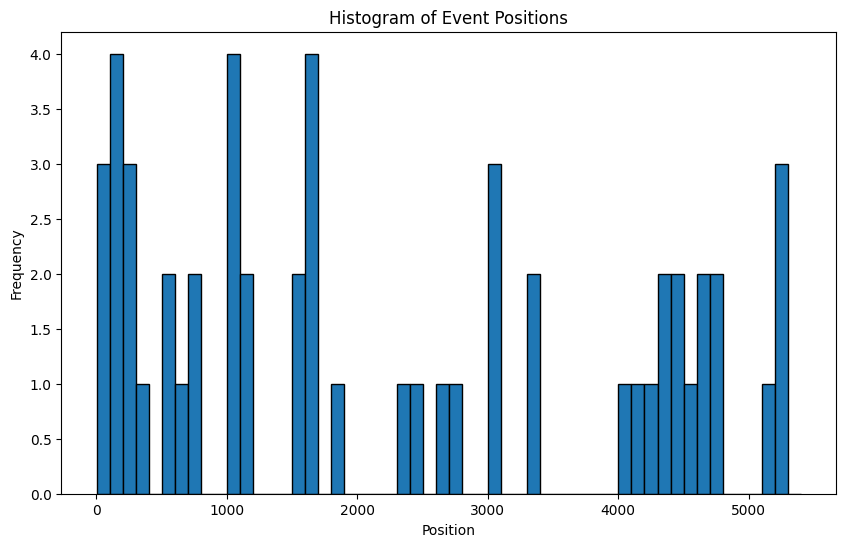

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(lineNumberList, bins=range(1, 5440, 100), edgecolor='black')
plt.title('Histogram of Event Positions')
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.show()

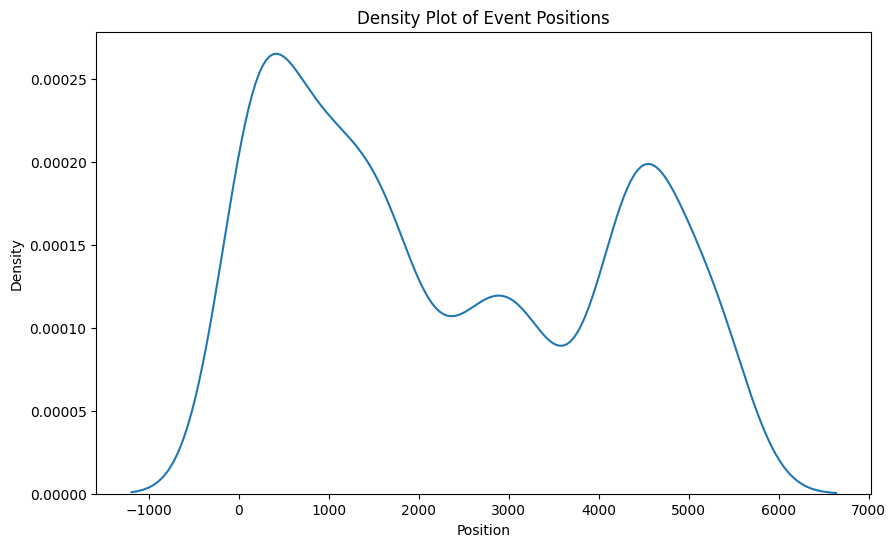

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(lineNumberList, bw_adjust=0.5)
plt.title('Density Plot of Event Positions')
plt.xlabel('Position')
plt.ylabel('Density')
plt.show()

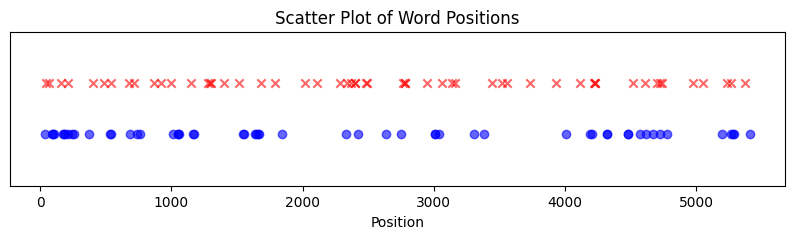

In [ ]:
plt.figure(figsize=(10, 2))
plt.scatter(lineNumberList, [1] * len(lineNumberList), alpha=0.6, label='Set 1', color='blue', marker='o')
plt.scatter(lineRandom, [2] * len(lineRandom), alpha=0.6, label='Set 2', color='red', marker='x')
plt.title('Scatter Plot of Word Positions')
plt.xlabel('Position')
plt.ylim(0, 3)
plt.yticks([])
plt.show()

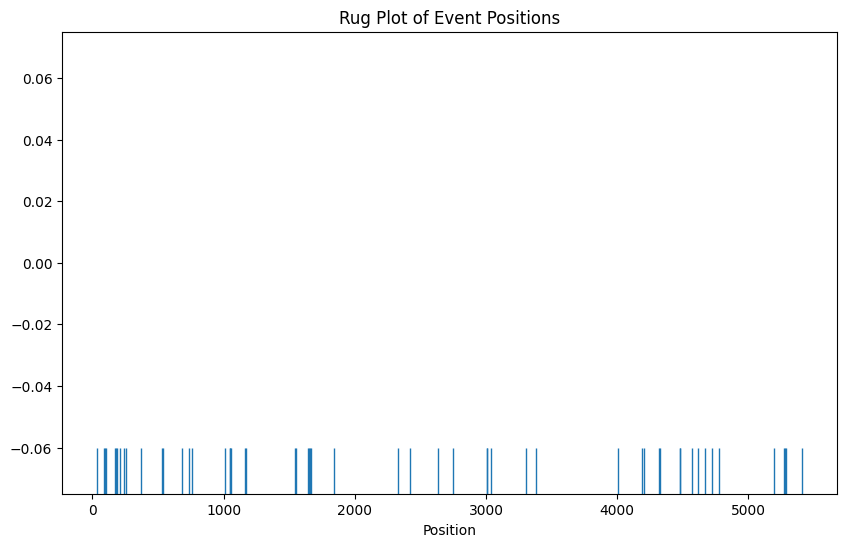

In [ ]:
plt.figure(figsize=(10, 6))
sns.rugplot(lineNumberList, height=0.1)
plt.title('Rug Plot of Event Positions')
plt.xlabel('Position')
plt.show()

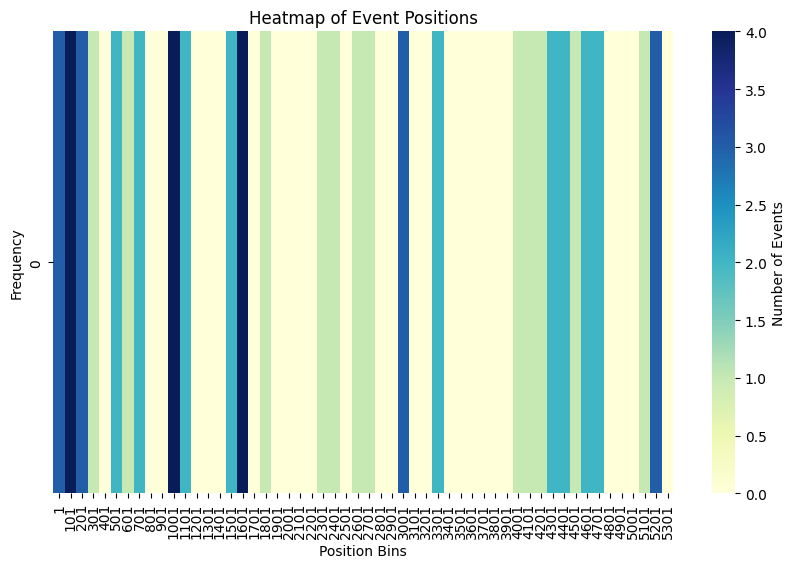

In [ ]:
# Create bins
bin_size = 100
bins = range(1, 5440, bin_size)
event_counts, _ = np.histogram(lineNumberList, bins=bins)

plt.figure(figsize=(10, 6))
sns.heatmap([event_counts], cmap="YlGnBu", cbar_kws={'label': 'Number of Events'})
plt.title('Heatmap of Event Positions')
plt.xlabel('Position Bins')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(len(bins)-1) + 0.5, labels=bins[:-1], rotation=90)
plt.show()
